# モデルの検証

In [26]:
from Library_chr2.seed import seed_torch
from Library_chr2.train_1epoch import train_1epoch

In [27]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import torch
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [28]:
def validate_1epoch(model, val_loader, lossfun, device):
    model.eval()
    total_loss, total_acc = 0.0, 0.0

    with torch.no_grad():
        for x, y in tqdm(val_loader):
            x = x.to(device)
            y = y.to(device)

            out = model(x)
            loss = lossfun(out, y)
            _, pred = torch.max(out, 1)

            total_loss += loss.item() * x.size(0)
            total_acc += torch.sum(pred == y.data)

    avg_loss = total_loss / len(val_loader.dataset)
    avg_acc = total_acc / len(val_loader.dataset)
    return avg_acc, avg_loss

In [29]:
def predict(model, loader, device):
    pred_fun = torch.nn.Softmax(dim=1)
    preds = []
    for x, _ in tqdm(loader):
        with torch.set_grad_enabled(False):
            x = x.to(device)
            y = pred_fun(model(x))
        y = y.cpu().numpy()
        y = np.argmax(y, axis=1)
        preds.append(y)
    preds = np.concatenate(preds)
    return preds

train_test_splitでデータを訓練データとテストデータに分けてから、
作成した訓練データから検証データを作成するため、さらに分割をする

In [30]:
seed_torch()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

digits = load_digits()
X = digits.data
y = digits.target

# train と test に分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# train から valid を切り出す
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=0)

In [31]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_valid = torch.tensor(X_valid, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
y_valid = torch.tensor(y_valid, dtype=torch.int64)
y_test = torch.tensor(y_test, dtype=torch.int64)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_dataset = TensorDataset(X_valid, y_valid)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [32]:
model = nn.Sequential(
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 10),
        )

model = model.to(device)
lossfun = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

train_losses = []
valid_losses = []

for ep in range(100):
    train_acc, train_loss = train_1epoch(
        model, train_loader, lossfun, optimizer, device
    )

    valid_acc, valid_loss = validate_1epoch(
        model, val_loader, lossfun, device
    )

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

100%|██████████| 4/4 [00:00<00:00, 1788.04it/s]


100%|██████████| 9/9 [00:00<00:00, 2705.23it/s]

train acc 0.9970149397850037
valid acc 0.9682539701461792
test acc 0.9629629629629629


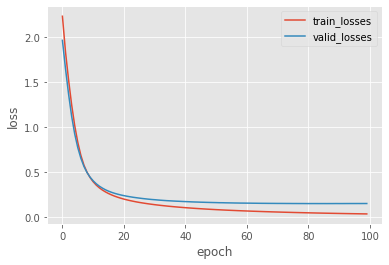

In [33]:
plt.plot(train_losses, label="train_losses")
plt.plot(valid_losses, label="valid_losses")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

test_preds = predict(model, test_loader, device)

print("train acc", train_acc.item())
print("valid acc", valid_acc.item())
print("test acc",
        sum(y_test.detach().numpy().copy() == test_preds) / len(y_test),
    )
